# <b> <center> <font color='#7B241C'> SIMPLE OBJECT LOCALIZATION</font> </center> </b>

## <font color='blue'> Table of Contents </font>

1. [Introduction](#1)
2. [Setup](#2)
3. [Helper Functions](#3)
4. [Data](#4) <br>
    4.1. [Generating synthetic data and exploring the dataset](#4.1) <br>
    4.2. [Image Pre-processing](#4.2) <br>
    4.3. [Annotation Pre-processing](#4.3) <br>
    4.4. [Load an example](#4.4) <br>
    4.5. [Train/Test Split](#4.5) <br>
    4.6. [Creating TF Datasets](#4.6) <br>
6. [Build, train and compile a model](#5)
7. [Evaluation](#6)
8. [Making predictions](#6)
9. [References](#references)

<a name="1"></a>
## <b> <font color='red'> 1. Introduction </font> </b>

In this notebook, we explore how to tackle an object localization problem using synthetic data. Object localization involves not only identifying the presence of an object in an image but also predicting its position, typically in the form of bounding box coordinates.

Working with real-world datasets can be costly and time-consuming due to the need for manual annotations. To overcome this, we'll generate synthetic data with automatic labels, enabling rapid experimentation and model prototyping.

This notebook will guide you through:

- Generating a simple synthetic dataset with known object positions,

- Building and training a convolutional neural network (CNN) to predict bounding boxes,

- Evaluating model performance and visualizing results.

By the end, you'll understand the end-to-end pipeline for object localization and appreciate the power of synthetic data in computer vision tasks.

<a name="2"></a>
## <b> <font color='red'> 2. Setup </font> </b>

In [137]:
import random
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import matplotlib.image as mpimg

In [138]:
tf.random.set_seed(42)

In [191]:
from dataclasses import dataclass

@dataclass
class DatasetConfig:
    batch_size: int
    height: int
    width: int
    img_size:int

config = DatasetConfig(batch_size=4, height=64, width=64, img_size=64)
print(config.batch_size, config.height, config.width, config.img_size)


4 64 64 64


<a name="3"></a>
## <b> <font color='red'> 3. Helper Functions </font> </b>


In [192]:
# To create the synthetic dataset

# Function to create bounding box XML
def create_voc_xml(filename, width, height, bbox, shape_name, folder="images"):
    annotation = ET.Element("annotation")
    ET.SubElement(annotation, "folder").text = folder
    ET.SubElement(annotation, "filename").text = filename
    ET.SubElement(annotation, "path").text = os.path.join(folder, filename)

    size = ET.SubElement(annotation, "size")
    ET.SubElement(size, "width").text = str(width)
    ET.SubElement(size, "height").text = str(height)
    ET.SubElement(size, "depth").text = "3"

    ET.SubElement(annotation, "segmented").text = "0"

    obj = ET.SubElement(annotation, "object")
    ET.SubElement(obj, "name").text = shape_name
    ET.SubElement(obj, "pose").text = "Unspecified"
    ET.SubElement(obj, "truncated").text = "0"
    ET.SubElement(obj, "difficult").text = "0"

    bndbox = ET.SubElement(obj, "bndbox")
    ET.SubElement(bndbox, "xmin").text = str(bbox[0])
    ET.SubElement(bndbox, "ymin").text = str(bbox[1])
    ET.SubElement(bndbox, "xmax").text = str(bbox[2])
    ET.SubElement(bndbox, "ymax").text = str(bbox[3])

    return ET.ElementTree(annotation)

# Function to draw shapes (circle or square) and return the bounding box
def draw_shape(img_size, shape_type="square"):
    shape_size = 10
    img = Image.new("RGB", (img_size, img_size), (255, 255, 255))
    draw = ImageDraw.Draw(img)

    x, y = random.randint(shape_size, img_size - shape_size), random.randint(shape_size, img_size - shape_size)
    xmin, ymin = x - shape_size, y - shape_size
    xmax, ymax = x + shape_size, y + shape_size

    if shape_type == "square":
        draw.rectangle([xmin, ymin, xmax, ymax], fill=(255, 0, 0))
    elif shape_type == "circle":
        draw.ellipse([xmin, ymin, xmax, ymax], fill=(0, 0, 255))

    return img, (xmin, ymin, xmax, ymax), shape_type


# plot an image
def plot_image(image_path, ):
    img = mpimg.imread(image_path)
    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    plt.axis('off')  # Hide axis
    plt.title("Sample Image")
    plt.show()


In [193]:
# Function to draw bounding box on an image for display
def draw_bbox(image_path, xml_path):
    img = Image.open(image_path).convert("RGB")
    tree = ET.parse(xml_path)
    root = tree.getroot()
    bndbox = root.find(".//bndbox")
    box = [int(bndbox.find(tag).text) for tag in ["xmin", "ymin", "xmax", "ymax"]]
    
    draw = ImageDraw.Draw(img)
    draw.rectangle(box, outline="green", width=2)
    return img

# Display a few images with bounding boxes
def plot_images_annotations(img_dir, ann_dir):
    plt.figure(figsize=(10, 2))
    for i, fname in enumerate(sorted(os.listdir(img_dir))[:5]):
        img_path = os.path.join(img_dir, fname)
        xml_path = os.path.join(ann_dir, fname.replace(".png", ".xml"))
        img_with_bbox = draw_bbox(img_path, xml_path)
        plt.subplot(1, 5, i+1)
        plt.imshow(img_with_bbox)
        plt.axis("off")
    plt.tight_layout()
    plt.show()


# Display the image with the predicted bounding box
def plot_image_with_bbox(image, predicted_class, predicted_bbox):
    plt.imshow(image)
    
    # Assuming the bounding box is in normalized coordinates (0-1), scale to image size
    xmin, ymin, xmax, ymax = predicted_bbox[0]  # Get the first bounding box
    
    # Scale the coordinates to the image size (64x64)
    xmin, ymin, xmax, ymax = xmin * 64, ymin * 64, xmax * 64, ymax * 64
    
    print("Scaled Bounding Box:", [xmin, ymin, xmax, ymax])
    
    # Plot the bounding box on the image
    plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                                      edgecolor='violet', facecolor='none', lw=2))
    plt.title(f"Predicted Class: {'Circle' if predicted_class == 1 else 'Square'}")
    plt.axis('off')
    plt.show()
    

<a name="4"></a>
## <b> <font color='red'> 4. Data </font> </b>

<a name="4.1"></a>
### <b> <font color='orange'> 4.1. Generating Syntethic Data and Exploring the Dataset</font> </b>

In [194]:
# Directories
img_dir = "shape_dataset/images"
ann_dir = "shape_dataset/annotations"
os.makedirs(img_dir, exist_ok=True)
os.makedirs(ann_dir, exist_ok=True)

# Image and shape parameters
img_size = config.img_size
shape_size = 10
num_images = 200  # Number of images to generate

# Generate images and annotations
for i in range(num_images):
    shape_type = random.choice(["square", "circle"])
    img, bbox, shape_name = draw_shape(img_size, shape_type)
    img_filename = f"{i:04d}.png"
    img.save(os.path.join(img_dir, img_filename))

    xml_filename = f"{i:04d}.xml"
    tree = create_voc_xml(img_filename, img_size, img_size, bbox, shape_name)
    tree.write(os.path.join(ann_dir, xml_filename))


**Note**. The previous code generates only one object per image.

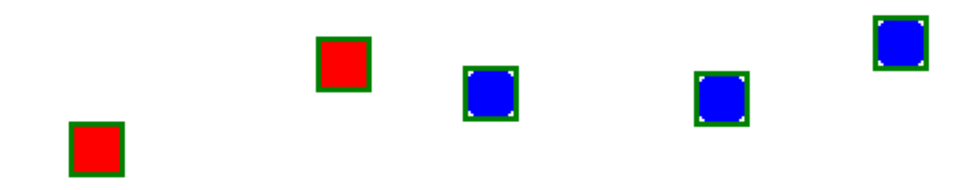

In [195]:
plot_images_annotations(img_dir, ann_dir)

In [196]:
!ls shape_dataset/images

0000.png  0025.png  0050.png  0075.png	0100.png  0125.png  0150.png  0175.png
0001.png  0026.png  0051.png  0076.png	0101.png  0126.png  0151.png  0176.png
0002.png  0027.png  0052.png  0077.png	0102.png  0127.png  0152.png  0177.png
0003.png  0028.png  0053.png  0078.png	0103.png  0128.png  0153.png  0178.png
0004.png  0029.png  0054.png  0079.png	0104.png  0129.png  0154.png  0179.png
0005.png  0030.png  0055.png  0080.png	0105.png  0130.png  0155.png  0180.png
0006.png  0031.png  0056.png  0081.png	0106.png  0131.png  0156.png  0181.png
0007.png  0032.png  0057.png  0082.png	0107.png  0132.png  0157.png  0182.png
0008.png  0033.png  0058.png  0083.png	0108.png  0133.png  0158.png  0183.png
0009.png  0034.png  0059.png  0084.png	0109.png  0134.png  0159.png  0184.png
0010.png  0035.png  0060.png  0085.png	0110.png  0135.png  0160.png  0185.png
0011.png  0036.png  0061.png  0086.png	0111.png  0136.png  0161.png  0186.png
0012.png  0037.png  0062.png  0087.png	0112.png  0137.png  0162.

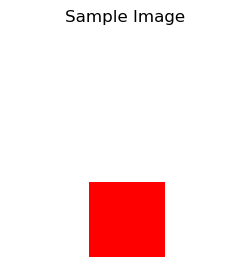

In [197]:
# plot an image
image_path = img_dir + "/0000.png"

plot_image(image_path)




In [198]:
!ls shape_dataset/annotations # are xmls

0000.xml  0025.xml  0050.xml  0075.xml	0100.xml  0125.xml  0150.xml  0175.xml
0001.xml  0026.xml  0051.xml  0076.xml	0101.xml  0126.xml  0151.xml  0176.xml
0002.xml  0027.xml  0052.xml  0077.xml	0102.xml  0127.xml  0152.xml  0177.xml
0003.xml  0028.xml  0053.xml  0078.xml	0103.xml  0128.xml  0153.xml  0178.xml
0004.xml  0029.xml  0054.xml  0079.xml	0104.xml  0129.xml  0154.xml  0179.xml
0005.xml  0030.xml  0055.xml  0080.xml	0105.xml  0130.xml  0155.xml  0180.xml
0006.xml  0031.xml  0056.xml  0081.xml	0106.xml  0131.xml  0156.xml  0181.xml
0007.xml  0032.xml  0057.xml  0082.xml	0107.xml  0132.xml  0157.xml  0182.xml
0008.xml  0033.xml  0058.xml  0083.xml	0108.xml  0133.xml  0158.xml  0183.xml
0009.xml  0034.xml  0059.xml  0084.xml	0109.xml  0134.xml  0159.xml  0184.xml
0010.xml  0035.xml  0060.xml  0085.xml	0110.xml  0135.xml  0160.xml  0185.xml
0011.xml  0036.xml  0061.xml  0086.xml	0111.xml  0136.xml  0161.xml  0186.xml
0012.xml  0037.xml  0062.xml  0087.xml	0112.xml  0137.xml  0162.

In [199]:
ann_path = ann_dir + "/0000.xml"

In [200]:
with open(ann_path, 'r') as file:
    print(file.read())


<annotation><folder>images</folder><filename>0000.png</filename><path>images/0000.png</path><size><width>64</width><height>64</height><depth>3</depth></size><segmented>0</segmented><object><name>square</name><pose>Unspecified</pose><truncated>0</truncated><difficult>0</difficult><bndbox><xmin>22</xmin><ymin>42</ymin><xmax>42</xmax><ymax>62</ymax></bndbox></object></annotation>


Let's print the annotation in a more friendly way.

In [201]:
import xml.dom.minidom

with open(ann_path, 'r') as file:
    xml_string = file.read()

# Parse and pretty-print
dom = xml.dom.minidom.parseString(xml_string)
pretty_xml = dom.toprettyxml()

print(pretty_xml)


<?xml version="1.0" ?>
<annotation>
	<folder>images</folder>
	<filename>0000.png</filename>
	<path>images/0000.png</path>
	<size>
		<width>64</width>
		<height>64</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>square</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>22</xmin>
			<ymin>42</ymin>
			<xmax>42</xmax>
			<ymax>62</ymax>
		</bndbox>
	</object>
</annotation>



In [202]:
# Parse the XML file
tree = ET.parse(ann_path)
root = tree.getroot()

# Extract filename
filename = root.find('filename').text

# Extract bounding box
bbox = root.find('object').find('bndbox')
xmin = int(bbox.find('xmin').text)
ymin = int(bbox.find('ymin').text)
xmax = int(bbox.find('xmax').text)
ymax = int(bbox.find('ymax').text)

# Print results
print(f"Filename: {filename}")
print(f"Bounding Box: ({xmin}, {ymin}), ({xmax}, {ymax})")



Filename: 0000.png
Bounding Box: (22, 42), (42, 62)


<a name="4.2"></a>
### <b> <font color='orange'> 4.2. Image Pre-processing </font> </b>

We will:

- Read and decode the image.
- Normalize to [0, 1].


In [203]:
img_path = image_path

img = tf.io.read_file(img_path)
img = tf.image.decode_png(img, channels=3)

# cast and normalizes to [0, 1] if the original image is an integer type (which is our case)
img = tf.image.convert_image_dtype(img, tf.float32)

In [204]:
img

<tf.Tensor: shape=(64, 64, 3), dtype=float32, numpy=
array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]], dtype=float32)>

<a name="4.3"></a>
### <b> <font color='orange'> 4.3. Annotation Pre-processing </font> </b>

We will:

- Identify the object class (e.g., square, circle) and encode it numerically.
- Extract the coordinates of the bounding box.
- Normalize the bounding box coordinates.



In [205]:
tree = ET.parse(ann_path)
root = tree.getroot()

In [206]:
label = root.find(".//name").text 
label

'square'

In [207]:
# encoding
label = 0 if label == "square" else 1 # square=0, circle=1
label

0

In [208]:
bbox = root.find(".//bndbox")
bbox

<Element 'bndbox' at 0x7b0b2b406110>

In [209]:
xmin = int(bbox.find("xmin").text)
ymin = int(bbox.find("ymin").text)
xmax = int(bbox.find("xmax").text)
ymax = int(bbox.find("ymax").text)

xmin, ymin, xmax, ymax

(22, 42, 42, 62)

In [210]:
# scaling the bounding box (images are config.img_size x config.img_size)
bbox_norm = [xmin / config.img_size, ymin / config.img_size, xmax / config.img_size, ymax / config.img_size]
bbox_norm

[0.34375, 0.65625, 0.65625, 0.96875]

We will put everything togeteher in one function.

In [211]:
# Parse annotation
def parse_xml(xml_file, img_size=config.img_size):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    label = root.find(".//name").text
    label = 0 if label == "square" else 1  # square=0, circle=1

    bbox = root.find(".//bndbox")
    xmin = int(bbox.find("xmin").text)
    ymin = int(bbox.find("ymin").text)
    xmax = int(bbox.find("xmax").text)
    ymax = int(bbox.find("ymax").text)

    # Normalize bbox coordinates
    bbox_norm = [xmin / img_size, ymin / img_size, xmax / img_size, ymax / img_size]
    return label, bbox_norm

<a name="4.4"></a>
### <b> <font color='orange'> 4.4. Load an example </font> </b>

In [212]:
# returns img + label (if it's circle or square) and the bounding box
def load_example(img_path, label, bbox):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)  # scale [0,1] the image
    return img, {"label": label, "bbox": bbox}


In [213]:
label , bbox = parse_xml(ann_path)

img, ann = load_example(img_path, label, bbox)

In [214]:
ann

{'label': 0, 'bbox': [0.34375, 0.65625, 0.65625, 0.96875]}

<a name="4.5"></a>
### <b> <font color='orange'> 4.5. Train/Test Split </font> </b>

Build a list of labeled image samples with their corresponding bounding boxes.

In [215]:
samples = []
for fname in sorted(os.listdir(img_dir)):
    if fname.endswith(".png"):
        img_path = os.path.join(img_dir, fname)                         # Path to image
        xml_path = os.path.join(ann_dir, fname.replace(".png", ".xml")) # Matching annotation path
        label, bbox = parse_xml(xml_path)                               # Extract label and bbox from XML
        samples.append((img_path, label, bbox))                         # Save as a tuple




In [216]:
samples[:5]

[('shape_dataset/images/0000.png', 0, [0.34375, 0.65625, 0.65625, 0.96875]),
 ('shape_dataset/images/0001.png', 0, [0.640625, 0.15625, 0.953125, 0.46875]),
 ('shape_dataset/images/0002.png', 1, [0.34375, 0.328125, 0.65625, 0.640625]),
 ('shape_dataset/images/0003.png',
  1,
  [0.546875, 0.359375, 0.859375, 0.671875]),
 ('shape_dataset/images/0004.png', 1, [0.4375, 0.03125, 0.75, 0.34375])]

Train/Test Split

In [217]:
# train/test split
random.shuffle(samples)
split_idx = int(0.8 * len(samples))
train_samples = samples[:split_idx]
val_samples = samples[split_idx:]

<a name="4.6"></a>
### <b> <font color='orange'> 4.6. Creating TF Datasets </font> </b>

In [218]:
def make_dataset(samples, batch_size=config.batch_size, training=True):
    """
    Creates a TensorFlow dataset for object localization from pre-processed data.

    Args:
        samples (list of tuples): Each tuple contains (image_path, label, bounding_box),
                                  where bounding_box is [xmin, ymin, xmax, ymax].
        batch_size (int): Number of samples per batch.
        training (bool): Whether to apply shuffling (useful for training mode).

    Returns:
        tf.data.Dataset: A batched and optionally shuffled dataset ready for model input.
    """
    # Unpack the samples into separate lists
    img_paths, labels, bboxes = zip(*samples)

    # Create a TensorFlow dataset from the image paths, labels, and bounding boxes
    ds = tf.data.Dataset.from_tensor_slices((list(img_paths), list(labels), list(bboxes)))

    # Map each element using the pre-processing function (assumes pre-processed inputs)
    ds = ds.map(lambda x, y, z: load_example(x, y, z))

    # Shuffle if in training mode
    if training:
        ds = ds.shuffle(100)

    # Batch the dataset and prefetch for better performance
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return ds


In [219]:
# Train and val datasets
train_ds = make_dataset(train_samples)
val_ds = make_dataset(val_samples,training=False)

In [220]:
for images, targets in train_ds.take(1):
    print("Images:", images.shape)
    print("targets:", targets)


Images: (4, 64, 64, 3)
targets: {'label': <tf.Tensor: shape=(4,), dtype=int32, numpy=array([1, 1, 0, 1], dtype=int32)>, 'bbox': <tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0.296875, 0.203125, 0.609375, 0.515625],
       [0.625   , 0.171875, 0.9375  , 0.484375],
       [0.640625, 0.546875, 0.953125, 0.859375],
       [0.390625, 0.625   , 0.703125, 0.9375  ]], dtype=float32)>}


In [221]:
for images, targets in train_ds.take(1):
    print("Images:", images.shape)
    print("Labels:", targets["label"])
    print("BBoxes:", targets["bbox"])

Images: (4, 64, 64, 3)
Labels: tf.Tensor([1 0 1 1], shape=(4,), dtype=int32)
BBoxes: tf.Tensor(
[[0.46875  0.3125   0.78125  0.625   ]
 [0.28125  0.171875 0.59375  0.484375]
 [0.       0.265625 0.3125   0.578125]
 [0.546875 0.359375 0.859375 0.671875]], shape=(4, 4), dtype=float32)


<a name="5"></a>
## <b> <font color='red'> 5. Build, compile and train a model </font> </b>

In [222]:
# Feature extractor
def feature_extractor(inputs):
    x = tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu')(inputs)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu')(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu')(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    return x

# Dense layers
def dense_layers(inputs):
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    return x

# Classification branch (2 classes)
def classifier(inputs):
    return tf.keras.layers.Dense(2, activation='softmax', name='label')(inputs)

# Bounding box regression branch (4 values)
def bounding_box_regression(inputs):
    return tf.keras.layers.Dense(4, name='bbox')(inputs)

# Complete model
def final_model(inputs):
    features = feature_extractor(inputs)
    dense = dense_layers(features)
    class_out = classifier(dense)
    bbox_out = bounding_box_regression(dense)
    return tf.keras.Model(inputs=inputs, outputs=[class_out, bbox_out])

# Compile model
def define_and_compile_model(input_shape=(64, 64, 3)):
    inputs = tf.keras.layers.Input(shape=input_shape)
    model = final_model(inputs)
    model.compile(
        optimizer='adam',
        loss={
            'label': 'sparse_categorical_crossentropy',
            'bbox': 'mse'
        },
        metrics={
            'label': 'accuracy',
            'bbox': 'mse'
        }
    )
    return model

# Instantiate and summarize
model = define_and_compile_model()
model.summary()


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_21 (Conv2D)          (None, 62, 62, 16)           448       ['input_8[0][0]']             
                                                                                                  
 average_pooling2d_21 (Aver  (None, 31, 31, 16)           0         ['conv2d_21[0][0]']           
 agePooling2D)                                                                                    
                                                                                                  
 conv2d_22 (Conv2D)          (None, 29, 29, 32)           4640      ['average_pooling2d_21[0

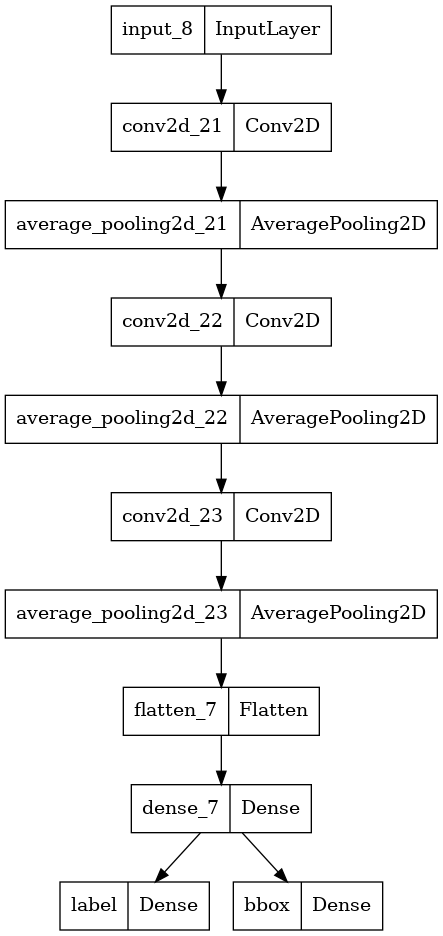

In [223]:
tf.keras.utils.plot_model(model, show_shapes=False, expand_nested=True)

Train the model:

In [224]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    verbose=0,
    epochs=20
)

<a name="6"></a>
## <b> <font color='red'> 6. Evaluation </font> </b>

In [226]:
loss, classification_loss, bounding_box_loss, classification_accuracy, bounding_box_mse = model.evaluate(val_ds, steps=1)
print("Validation accuracy: ", classification_accuracy)

1/1 [==============================] - 0s 16ms/step - loss: 0.0022 - label_loss: 1.1381e-04 - bbox_loss: 0.0021 - label_accuracy: 1.0000 - bbox_mse: 0.0021
Validation accuracy:  1.0


For the bounding boxes, a better evaluation metric than MSE would be IoU.

In [227]:
def intersection_over_union(pred_box, true_box):
    xmin_pred, ymin_pred, xmax_pred, ymax_pred = pred_box
    xmin_true, ymin_true, xmax_true, ymax_true = true_box
    

    smoothing_factor = 1e-10

    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    overlap_area = np.maximum((xmax_overlap - xmin_overlap), 0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou

Evaluation on the validation dataset.

In [228]:
def evaluate_iou_on_dataset(model, val_ds):
    """
    Computes the average IoU over the validation dataset.

    Args:
        model: A model that outputs [class_probs, predicted_bboxes].
        val_ds: A tf.data.Dataset yielding (images, {'label': ..., 'bbox': true_boxes}).

    Returns:
        float: Mean IoU across all valid samples.
    """
    ious = []

    for images, targets in val_ds:
        true_boxes = targets['bbox'].numpy()
        class_probs, pred_boxes = model.predict(images)  # Unpack outputs
        pred_boxes = pred_boxes.squeeze()  # shape: (batch_size, 4)

        for pred_box, true_box in zip(pred_boxes, true_boxes):
            if len(pred_box) == 4 and len(true_box) == 4:
                iou = intersection_over_union(pred_box, true_box)
                ious.append(iou)

    return np.mean(ious) if ious else 0.0


In [229]:
evaluate_iou_on_dataset(model, val_ds)

1/1 [==============================] - 0s 19ms/step


0.6334521186367139

<a name="7"></a>
## <b> <font color='red'> 7. Making predictions </font> </b>

1/1 [==============================] - 0s 21ms/step
Predicted class: [1]
Predicted bbox: [[0.2946466  0.35545123 0.5741187  0.6585289 ]]
Label: {'label': <tf.Tensor: shape=(4,), dtype=int32, numpy=array([1, 0, 0, 1], dtype=int32)>, 'bbox': <tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0.359375, 0.390625, 0.671875, 0.703125],
       [0.171875, 0.453125, 0.484375, 0.765625],
       [0.296875, 0.3125  , 0.609375, 0.625   ],
       [0.59375 , 0.234375, 0.90625 , 0.546875]], dtype=float32)>}
Scaled Bounding Box: [18.85738182067871, 22.748878479003906, 36.743595123291016, 42.145851135253906]


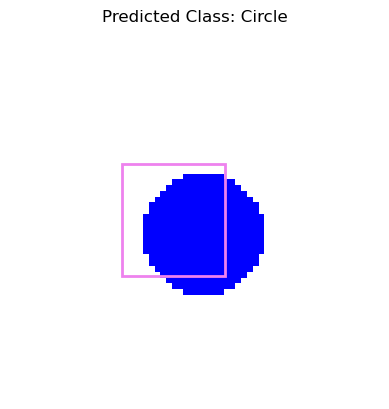

In [230]:
# Get one batch from the val_ds
image_batch, label_batch = next(iter(val_ds))

# Get the first image from the batch (assuming the batch size is > 1)
image = image_batch[0]
label = label_batch #[0]

# Make a prediction using the model
predictions = model.predict(tf.expand_dims(image, axis=0))  # Add batch dimension

# Assuming the predictions are in two parts (classification and bounding box)
predicted_class = np.argmax(predictions[0], axis=1)  # Classification prediction
predicted_bbox = predictions[1]  # Bounding box prediction

print("Predicted class:", predicted_class)
print("Predicted bbox:", predicted_bbox)

print("Label:", label)

# Plot the image and bounding box
plot_image_with_bbox(image, predicted_class, predicted_bbox)


<a name="references"></a>
## <b> <font color='red'> References </font>  </b>

[TF Advanced Techniques Specialization](https://www.coursera.org/specializations/tensorflow-advanced-techniques)